# Tuning and Inspecting Model Trees
I've mentioned in passing a few times that we don't have to come up with parameters for building models all by ourselves - we can leverage sklearn's built in functionality for this through a process called `GridSearch`. This method allows you to describe the different parameter values you want to explore, and build individual models for each one. The result is that once you think you have some indication that your features might be reasonable - and I think we have that already - you can fine tune the model through brute computation.

In [1]:
# Let's load in our data from the previous lecture
import pandas as pd
import numpy as np
%run m5p.py

df=pd.read_csv("assets/model_tree_data.csv")
X_train=df[ df.columns.drop('normalized_vote_pct') ]
y_train=df['normalized_vote_pct']

# GridSearch comes in a cross validation variety, so let's import that
from sklearn.model_selection import GridSearchCV

# Now, let's set a few different hyperparameters the M5Prime class can work with
# I'm going to choose to explore a few different depths, a few minimum number of
# samples per leaf, and a few pruning options
parameters={'max_depth':(3,4,5,6), 
            'min_samples_leaf':(1,3,6),
            'use_pruning':[False,True],
            }

# Now we can just train our model as if it were a regression model directly. Be
# aware that this will take a bit of time to run
reg=GridSearchCV(estimator=M5Prime(use_smoothing=False), param_grid=parameters, cv=10, scoring='r2')
reg.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=M5Prime(leaf_model=DeNormalizableLinearRegression(),
                               use_smoothing=False),
             param_grid={'max_depth': (3, 4, 5, 6),
                         'min_samples_leaf': (1, 3, 6),
                         'use_pruning': [False, True]},
             scoring='r2')

In [2]:
# We already know what out naive approach did, with a max_depth=6,
# and min_samples_leaf=3, we had an R2 around 0.28. Now we can look at
# the best model with the parameters we have tried through grid search
reg.best_score_

0.35711481724395

In [3]:
# Well, that's not amazingly better. But it's something, we can find lots more
# detail about this model in the cv_results_ attribute, including the time and R2
# values for every fold and every parameter combination! But If we just want
# to see the best set of parameters, the ones which correspond to the score
# above, we can get those too.
reg.best_params_

{'max_depth': 4, 'min_samples_leaf': 6, 'use_pruning': True}

Now, there are lots of other investigations we could consider, including expanding our `GridSearchCV` results or changing the regression model we use for leaf nodes. But, I did sort of sell the M5 trees as an interpretable approach to the problem, and maybe we should take a minute to look at that. Recall that our task is to generate a list of NHL players for a given season and the number of votes they will receive for the Hart trophy by journalists. Votes are weighted, and we've chosen to predict the normalized weighting value. We should be able to look at a sorted list of our predictions and compare to our validation year -- the 2018-2019 year. We also should be able to look at our tree and gain some insight into how it comes up with classifications. So let's do that now.

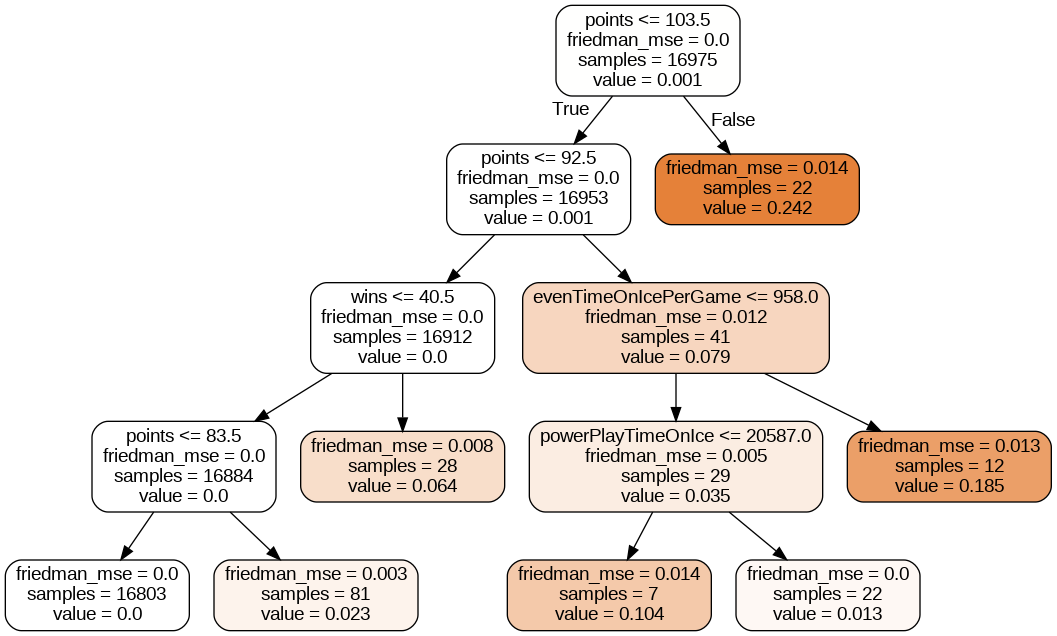

In [4]:
# There are a few ways we can look at our model. I'm going to start just by visualizing
# the tree as a set of nodes. So let's take our best model, which can be found in
# reg.best_estimator_, and predict on our training data
from sklearn.tree import export_graphviz
export_graphviz(reg.best_estimator_, out_file="m5p_tree.dot", 
                feature_names=X_train.columns, rounded=True, filled=True)

# Now we convert this to a PNG for display and load it up here in a new cell
!dot -Tpng m5p_tree.dot -o m5p_tree.png
from IPython.display import Image
display(Image('m5p_tree.png'))

In [5]:
# Ok, that was a lot to talk about. The tree is just part of the analysis though, we
# also have those regression equations at each leaf node. Recall that a regression
# equation is a bunch of coefficients, one for each feature, that are effectively a
# weighting which when summed together will produce a target value - in this case our
# percentage of votes. Now we can get these equations in a few ways, but Sylvain has nicely
# included a function which prints out the tree nodes and the linear model equations for
# us as well.
print(export_text_m5(reg.best_estimator_, out_file=None, node_ids=True))
for i,v in enumerate(X_train.columns):
    print(f"{i}: {v}")

M5Prime (unsmoothed - but this can be done at prediction time):

0| X[9] <= 103.5 [friedman_mse=0.0, samples=16975] (err=0.009, params=17)
1| |   X[9] <= 92.5 [friedman_mse=0.0, samples=16953] (err=0.008, params=13)
2| |   |   X[18] <= 40.5 [friedman_mse=0.0, samples=16912] (err=0.007, params=6)
3| |   |   |   X[9] <= 83.5 [friedman_mse=0.0, samples=16884] (err=0.007, params=3)
4| |   |   |   |   LEAF [friedman_mse=0.0, samples=16803] : 0.0 (err=0.005, params=1)
5| |   |   |   |   LEAF [friedman_mse=0.003, samples=81] : 0.023 (err=0.054, params=1)
6| |   |   |   LEAF [friedman_mse=0.008, samples=28] : LM1 (err=0.076, params=2)
7| |   |   X[39] <= 958.0 [friedman_mse=0.012, samples=41] (err=0.071, params=6)
8| |   |   |   X[40] <= 20587.0 [friedman_mse=0.005, samples=29] (err=0.06, params=3)
9| |   |   |   |   LEAF [friedman_mse=0.014, samples=7] : 0.104 (err=0.118, params=1)
10| |   |   |   |   LEAF [friedman_mse=0.0, samples=22] : 0.013 (err=0.017, params=1)
11| |   |   |   LEAF [frie

In [6]:
# Ok, let's make this prediction on our holdout! We don't need to retrain
# we can just use our best estimator on the data we haven't seen 
df_validate=pd.read_csv("assets/model_tree_holdout_data.csv")

X_validate=df_validate[ df_validate.columns.drop('normalized_vote_pct').drop('fullName') ]
y_validate=df_validate['normalized_vote_pct']

reg.best_estimator_.score(X_validate,y_validate)

-0.060144438520332466

Wow, that's a poorly fitting model. How can you even have an $R^2$ value which is negative? Well, what this means is that overall in our regression analysis a constant horizontal line would be a better predictor. That this horizontal line constant would better fit our data than the models we have trained. So, is all hope lost? I don't think so. While we have modeled this problem as a regression problem, our real-world use case is more likely to be something akin to ranking the players who are in the top ten or twents as far as their competitiveness for the Hart Trophy. And this shows some of the gritty challenges in applying machine learning to sports data -- your conceptualization of the problem influences your model and evaluation methods.

So, what do we do next? Well, let's actually see how the top ten people in our model compare to the people who received votes in the top ten for that holdout year.

In [7]:
# let's embed our prediction data in the df_validate dataframe
df_validate[f"prediction_full_data"]=reg.best_estimator_.predict(X_validate)

# and we'll both sort the values in this dataframe by the prediction and reset our index
df_validate=df_validate[['fullName',"prediction_full_data"]].sort_values(by="prediction_full_data", ascending=False).reset_index()

# Now let's pull down the data from hockey reference
# Uncomment to run if not on Coursera
# hr=pd.read_html('https://www.hockey-reference.com/awards/voting-2019.html#all-hart-stats')[0]
# hr.columns=hr.columns.droplevel(0)
# hr=hr[["Place","Player","Vote%"]]
# hr.to_csv("assets/hocket-reference-20182019.csv", index=False)
hr= pd.read_csv("assets/hocket-reference-20182019.csv")

# Now we can just join the two dataframes together on the index and see
# how we compare to the actuals
df_validate[['fullName',"prediction_full_data"]].join(hr,how='inner')

,fullName,prediction_full_data,Place,Player,Vote%
0,Nikita Kucherov,0.293477,1,Nikita Kucherov,98.07
1,Patrick Kane,0.279518,2,Sidney Crosby,43.22
2,Aleksander Barkov,0.254478,3,Connor McDavid,27.19
3,Connor McDavid,0.238742,4,Johnny Gaudreau,25.85
4,Johnny Gaudreau,0.173244,5,Brad Marchand,18.83
5,Nathan MacKinnon,0.173244,6,Nathan MacKinnon,15.50
6,Sidney Crosby,0.146166,7,Alex Ovechkin,12.46
7,Leon Draisaitl,0.127124,8,Patrick Kane,7.31
8,Mitchell Marner,0.103670,9,Mark Giordano,3.86
9,Brad Marchand,0.103670,10,Sebastian Aho,1.23
